# Brain storming ideas to orchestrate new featurse and try them in practice

## Some ideas to try:
1. GuestRooms/Rooms: GuestRooms to Rooms ratio 
2. Rooms/Floors: Number of rooms per floor
3. Attic/squareMeters:  Attic size to total house size ratio
4. Basement/squareMeters: Basement size to total house size ratio
5. Garage/squareMeters: Garage size to total house size ratio
6. Group zip codes by like all starting with 35 in one bucket etc and add a avgCost per house in the area feature. maybe create buckets like 0-100, 100-200, 200-300 etc

In [ ]:
!pip install mplcyberpunk

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mplcyberpunk

import os
from pathlib import Path
import xgboost as xgb
import lightgbm as lgbm
import catboost
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error
from IPython.display import display
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
import optuna
from sklearn.preprocessing import StandardScaler

In [5]:
from warnings import filterwarnings
filterwarnings("ignore")

plt.style.use("cyberpunk")

# Loading Data

In [6]:
# setting a base path variable for easy access
BASE_PATH = Path("/kaggle/input/playground-series-s3e6")
train = pd.read_csv(BASE_PATH / "train.csv").drop(columns=["id"])

test = pd.read_csv(BASE_PATH / "test.csv")
# we need the test id column to make the submission
test_idx = test.id
test = test.drop(columns=["id"])

# we also load original dataset and will try to gauge if adding it to the competition datasets boosts our score or not
original = pd.read_csv("/kaggle/input/paris-housing-price-prediction/ParisHousing.csv")

### Features Presence Check
Checkingg if the competition dataset and original dataset contain the same features in same order, so we can concatenate them easily. Otherwise we'll have to manually make them consistent

In [7]:
all(original.columns == train.columns)

True

#### Result:
Well both dataset indeed contain the same features in the same order. No need for any manual work!

In [14]:
all_datasets = {"train": train, "test": test,"original": original}

# Analyzing Data
Here I won't go in detail about the features distribution similarities and contrasts between the competition and original datasets because that would make this notebook quite complicated for newcomers to this platform and field.

I'll most probably make a separate notebook for this comparison b/w competition and original dataset.

## Checking for missing values

In [15]:
pd.concat([dataset.isnull().sum().rename(f"Missing in {dataset_name}") 
               for dataset_name, dataset in all_datasets.items()],
                 axis=1)

,Missing in train,Missing in test,Missing in original
squareMeters,0,0.0,0
numberOfRooms,0,0.0,0
hasYard,0,0.0,0
hasPool,0,0.0,0
floors,0,0.0,0
cityCode,0,0.0,0
cityPartRange,0,0.0,0
numPrevOwners,0,0.0,0
made,0,0.0,0
isNewBuilt,0,0.0,0


### INSIGHTS:
We're in luck, none of the datasets contain any missing value.

Also test dataframe has **NaN** for price because it doesn't contain price i.e. target feature.

# Preprocess

In [27]:
def preprocess(datasets:dict, target:str):
    """Preprocess the data
        datasets: Expects a dict with datasets name as keys and datasets as values
            Valid names for dataets are: [train, test, original]
        
        target: name of the target column
    """
    for dataset_name, dataset in datasets.items():
        if dataset_name == "train":
            y = train[target]
            X = train.drop(columns=[target])
        elif dataset_name == "original":
            y_org = original[target]
            X_org = original.drop(columns=[target])
        elif dataset_name == "test":
            X_test = test.copy()
        
        
    X_combined = pd.concat([X, X_org], axis=0)
    y_combined = pd.concat([y, y_org], axis=0)

    return {"train": {"data": X, "target": y}, "original": {"data": X_org,  "target": y_org},
            "combined": {"data": X_combined, "target": y_combined}, "test": {"data": X_test}}    

In [43]:
processed_datasets = preprocess(all_datasets, "price")

X, y = processed_datasets["train"].values()
X_org, y_org = processed_datasets["original"].values()
X_combined, y_combined = processed_datasets["combined"].values()
X_test = processed_datasets["test"].values()

# Cross Validate

In [50]:
def cross_validate(X, y, X_org, y_org, model, model_verbose):
    N_FOLDS = 8
    cv_scores = np.zeros(N_FOLDS)
    feature_importances_all_folds = np.zeros(shape=(N_FOLDS, len(X.columns)))
    feature_names = X.columns
    
    kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=1337)
    
    for fold_num, (train_idx, val_idx) in enumerate(kf.split(X)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # As has been shown in the previous competitions that
        # train on the combined(competition + original) dataset
        # but evaluate only on competition dataset
        
        X_train = pd.concat([X_train, X_org], axis=0)
        y_train = pd.concat([y_train, y_org], axis=0)
        
        if model=="XGBoost":
            model = xgb.XGBRegressor(tree_method="gpu_hist")
        elif model=="LightGBM":
            model = lgbm.LGBMRegressor(device="gpu")
        elif model=="CatBoost":
            model = catboost.CatBoostRegressor(eval_metric="RMSE", task_type="GPU")
        
        model.fit(X_train, y_train,
                  eval_set=[(X_val, y_val)],
                  early_stopping_rounds=50,
                 verbose=model_verbose)
        
        y_preds = model.predict(X_val)
        
        # to calculate rmse instead of mse, we set squared=False
        rmse = mean_squared_error(y_val, y_preds, squared=False)
        cv_scores[fold_num] = rmse        
        print(f"Fold {fold_num} \t RMSE: {rmse}")
        
        # we'll average feature importances across all folds and plot the averaged values
        feature_importances_all_folds[fold_num] = model.feature_importances_
        
    avg_rmse = np.mean(cv_scores)
    print(f"AVG RMSE: {avg_rmse}")
    
    avg_feature_importances = np.mean(feature_importances_all_folds, axis=0)
    
    plot_feature_importances(feature_names, avg_feature_importances)

# Plot Feature Importances

In [45]:
def plot_feature_importances(feature_names, feature_importances):
    fig = plt.figure(figsize = (15, 0.35*len(feature_importances)))
    feature_imp_df = pd.DataFrame(data=zip(feature_names, feature_importances), columns=["feature", "importance"]).sort_values(by="importance", ascending=False)
    plt.title('Feature importances', size=25, y=1.05)
    sns.barplot(data=feature_imp_df, x='importance', y='feature')
    plt.show()

# Feature Engineering
## Some ideas to try:
1. GuestRooms/Rooms: GuestRooms to Rooms ratio 
2. Rooms/Floors: Number of rooms per floor
3. Attic/squareMeters:  Attic size to total house size ratio
4. Basement/squareMeters: Basement size to total house size ratio
5. Garage/squareMeters: Garage size to total house size ratio
6. Group zip codes by like all starting with 35 in one bucket etc. maybe create buckets like 0-100, 100-200, 200-300 etc. This way some areas may emerge where land value is more expensive than others

In [46]:
def try_new_feature(X, y, X_org, y_org):    
    models = ["XGBoost", "LightGBM", "CatBoost"]
    
    for model in models:
        print(f"{'-'*20} {model} {'-'*20}")
        
        verbose = False
        if model=="LightGBM":
            verbose = -1
            
        cross_validate(X, y, X_org, y_org, model=model, model_verbose=verbose)

## Setting a baseline

-------------------- XGBoost --------------------
Fold 0 	 RMSE: 154188.27278516119
Fold 1 	 RMSE: 127635.99800495614
Fold 2 	 RMSE: 66390.78593262316
Fold 3 	 RMSE: 168424.67336041204
Fold 4 	 RMSE: 73247.73085932412
Fold 5 	 RMSE: 284545.5162397819
Fold 6 	 RMSE: 177638.5351377841
Fold 7 	 RMSE: 63436.759232980054
AVG RMSE: 139438.53394412785


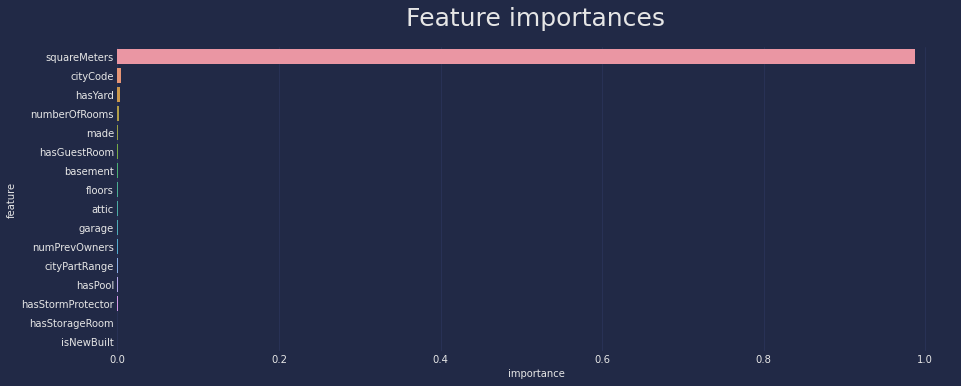

-------------------- LightGBM --------------------
Fold 0 	 RMSE: 171301.47035466178
Fold 1 	 RMSE: 155822.76775984338
Fold 2 	 RMSE: 56447.042274015235
Fold 3 	 RMSE: 202119.25533245484
Fold 4 	 RMSE: 61658.562946096485
Fold 5 	 RMSE: 285890.72441570566
Fold 6 	 RMSE: 209641.8411362364
Fold 7 	 RMSE: 88189.80989517206
AVG RMSE: 153883.9342642732


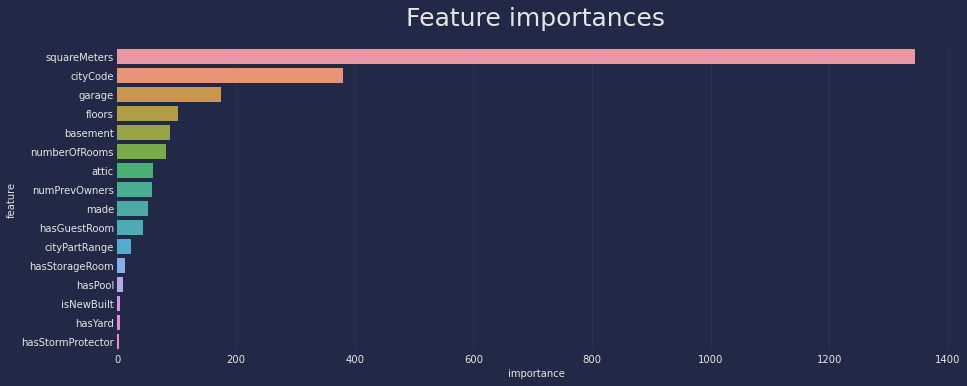

-------------------- CatBoost --------------------


TypeError: fit() got an unexpected keyword argument 'eval_metric'

In [51]:
try_new_feature(X, y, X_org, y_org)

In [24]:
train_fe = train.copy()

In [ ]:
# featIdea #1
train_fe["guestRooms_/_numberOfRooms"] = train_fe.hasGuestRoom / train_fe.numberOfRooms

In [23]:
# featIdea #6
train_fe = (train.cityCode // 100)

996

In [ ]:
pd.cut(train.)

## Checking for Categorical Values
We now check if our dataset contains any categorical features, if so we'll encode them before feeding to our model

In [8]:
train.hasGuestRoom

0        3
1        6
2        9
3        9
4        7
        ..
22725    0
22726    7
22727    0
22728    0
22729    6
Name: hasGuestRoom, Length: 22730, dtype: int64

In [10]:
pd.concat([train.dtypes.rename("Data Type"),
          train.nunique().rename("Unique Values")], axis=1).sort_values(by="Unique Values")

,Data Type,Unique Values
hasYard,int64,2
hasPool,int64,2
hasStorageRoom,int64,2
isNewBuilt,int64,2
hasStormProtector,int64,2
cityPartRange,int64,10
numPrevOwners,int64,10
hasGuestRoom,int64,11
made,int64,33
numberOfRooms,int64,100


### INSIGHTS:

These features hasYard, hasPool, hasStorageRoom, isNewBuilt, hasStormProtector, are already binary encoded, as they contain either 0 or 1. So though they are categorical, we don't need to encode them.

cityPartRange, numPreviousOwners, hasGuestRoom, made are good candidates for categorical features.

In [36]:
features_to_encode = [col for col in train.columns 
                      if train[col].nunique() <= 33 and train[col].nunique() > 2]
features_to_encode

['cityPartRange', 'numPrevOwners', 'made', 'hasGuestRoom']

## Deciding which encoding technique to use
We could use simple one hot encoding, but that would add 64 new features, which for a dataset of this size seems quite high.
There are many alternative and better encoding techniques available, but we'll use OridinalEncoder here which makes intuitive sense for these features (other than cityPartRange, no idea what that means).

In [ ]:
# # counting the number of new columns we'll add if we do one hot encoding
# total_new_possible_cols = 0
# for col in features_to_encode:
#     total_new_possible_cols += train[col].nunique()
    
# total_new_possible_cols

In [37]:
oe = OrdinalEncoder()

train[features_to_encode] = oe.fit_transform(train[features_to_encode])
test[features_to_encode] = oe.transform(test[features_to_encode])
original[features_to_encode] = oe.transform(original[features_to_encode])

# Preprocessing

In [38]:
X = train.drop(columns=["price"])
y = train.price

X_org = original.drop(columns=["price"])
y_org = original.price

In [39]:
X_combined = pd.concat([X, X_org], axis=0)
y_combined = pd.concat([y, y_org], axis=0)

# Modelling
Before we train our models, it's a good idea to set up cross validation

## Setting up K-Fold Cross Validation

## XGBoost

In [40]:
xgb_reg = xgb.XGBRegressor()
# cross_validate(X, y, X_org, y_org, xgb_reg, model_verbose=False)
xgb_reg.fit(X_combined, y_combined)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [58]:
xgb_reg.feature_names_in_

array(['squareMeters', 'numberOfRooms', 'hasYard', 'hasPool', 'floors',
       'cityCode', 'cityPartRange', 'numPrevOwners', 'made', 'isNewBuilt',
       'hasStormProtector', 'basement', 'attic', 'garage',
       'hasStorageRoom', 'hasGuestRoom'], dtype='<U17')

In [57]:
xgb_reg.feature_importances_

array([9.8416418e-01, 1.4112649e-03, 6.7620538e-03, 6.0063267e-05,
       6.1237888e-04, 3.7066003e-03, 2.3919067e-04, 3.7742316e-04,
       9.5135724e-04, 1.4052415e-05, 4.1520698e-06, 3.5218120e-04,
       5.7883444e-04, 3.0571915e-04, 1.1316456e-05, 4.4925351e-04],
      dtype=float32)

In [ ]:
y_pred_xgb = xgb_reg.predict(test)

## LightGBM

In [ ]:
# lgbm_reg = lgbm.LGBMRegressor()
# cross_validate(X, y, X_org, y_org, lgbm_reg, model_verbose=-1)

In [ ]:
# slightly tuned params - make sure to tune yours properly
lgbm_params = {'n_estimators': 667,
                 'num_rounds': 404,
                 'learning_rate': 0.19,
                 'num_leaves': 17,
                 'max_depth': 8,
                 'min_data_in_leaf': 36,
                 'lambda_l1': 0.96,
                 'lambda_l2': 0.01,
                 'min_gain_to_split': 11.32,
                 'bagging_fraction': 0.6,
                 'feature_fraction': 0.9}

lgbm_reg = lgbm.LGBMRegressor(**lgbm_params)
# cross_validate(X, y, X_org, y_org, lgbm_reg, model_verbose=-1)
lgbm_reg.fit(X_combined, y_combined)

In [ ]:
y_pred_lgbm = lgbm_reg.predict(test)

## CatBoost

In [ ]:
catboost_reg = catboost.CatBoostRegressor()

# cross_validate(X, y, X_org, y_org, catboost_reg, model_verbose=False)

catboost_reg.fit(X_combined, y_combined, verbose=False)

In [ ]:
y_pred_cat = catboost_reg.predict(test)

# Ensembling
Though there are more advanced and better ensembling techniques available out there, we'll just use the simple average here.

In [ ]:
test.shape

In [ ]:
y_pred_final = np.array([y_pred_xgb, y_pred_lgbm, y_pred_cat]).mean(axis=0)

In [ ]:
submission = pd.DataFrame({'id': test_idx, 'price': y_pred_final})
submission.head()

In [ ]:
submission.to_csv("submission.csv", index=False)